# Function Definitions

In [2]:
import pandas as pd 
import matplotlib
import os 
import matplotlib.pyplot as plt
import numpy as np
from math import factorial
from PyNomaly import loop
    

def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    #! Source: https://scipy.github.io/old-wiki/pages/Cookbook/SavitzkyGolay

    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')


def print_dataframe_pls(dataframe):
    with pd.option_context('display.max_rows', None,
                        'display.max_columns', None,
                        'display.precision', 3,
                        ):
        print(dataframe)


def trim_data(filename: str):
    # sourcery skip: use-fstring-for-formatting
    """
    Returns a trimmed DataFrame of pvc gel temperature experiment trial with 650 data points. The last 250 data
    points of the experiment are omitted, and are not included in the 650 data points. 
    The data is trimmed at the stopping point, which is identified when the load dramatically changes 
    indicating that the plunger has been lifted off of the gel quickly (which is what happens when
    the experiment is finished)
    """

    first_test = pd.read_csv(filepath_or_buffer = r"C:\Users\asenn\OneDrive\School\Research\MSIPP (Georgia 2023)\Raw Temperature Data\{}".format(filename), skiprows=18)
    split_df_index_location = first_test.diff().multiply(-1).idxmax()[0]

    load_channel_raw = first_test.iloc[:split_df_index_location,:].dropna(axis=1)
    # Drop last row in load_channel so that load_channel and pvc_channel have the same length 
    load_channel_raw.drop([len(load_channel_raw)-1], inplace=True)
    # Multiply to make sure that Load is in grams 10 mV = 250g 
    load_channel = load_channel_raw.multiply(other= [1, -1000 * 25])

    # Sort pvc data into separate DataFrame to combine later 
    pvc_channel = first_test.iloc[split_df_index_location:,:].dropna(axis=1).drop(columns=['Relative Time']).reset_index(drop = True)  * -1000 # Convert V to mV 

    # Combine DataFrames into n x 3 DataFrame() with Time, Load and PVC Response 
    main_df_untrimmed = pd.concat((load_channel, pvc_channel), axis=1)

    stopping_point = main_df_untrimmed.diff().multiply(-1).idxmax()[1]

    main_df_trimmed = main_df_untrimmed[stopping_point - 900:stopping_point-250]

    # Rename columns from CH1XX to Load and Response
    main_df_trimmed.rename({'CH110':'Load (g)', 'CH108':'Response (mV)'}, inplace=True, axis = 1)

    return main_df_trimmed





# One graph: all trials - noisy (response vs. time) saves graph .jpg automatically

C:\Users\asenn\AppData\Local\Temp\ipykernel_25944\2627318467.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df_trimmed.rename({'CH110':'Load (g)', 'CH108':'Response (mV)'}, inplace=True, axis = 1)
C:\Users\asenn\AppData\Local\Temp\ipykernel_25944\2627318467.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df_trimmed.rename({'CH110':'Load (g)', 'CH108':'Response (mV)'}, inplace=True, axis = 1)
C:\Users\asenn\AppData\Local\Temp\ipykernel_25944\2627318467.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pand

['_A', '_PROPERTIES_EXCLUDED_FROM_SET', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_agg_filter', '_alias_map', '_alpha', '_animated', '_antialiaseds', '_axes', '_bcast_lwls', '_callbacks', '_capstyle', '_clipon', '_clippath', '_cm_set', '_default_contains', '_edge_default', '_edge_is_mapped', '_edgecolors', '_face_is_mapped', '_facecolors', '_factor', '_fully_clipped_to_axes', '_get_default_antialiased', '_get_default_edgecolor', '_get_default_facecolor', '_get_default_linewidth', '_gid', '_hatch', '_hatch_color', '_id_norm', '_in_layout', '_internal_update', '_joinstyle', '_label', '_linestyles', '_linewidths', '_mapped_colors', '_mouseover', '_norm', '_offset_transform', 

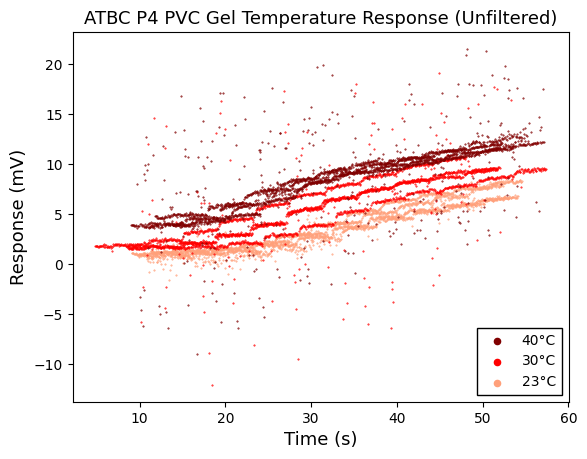

In [3]:
# #############################################################################! Trim and display all data (voltage vs. time) ##########################################################################################################
 


directory = r"C:\Users\asenn\OneDrive\School\Research\MSIPP (Georgia 2023)\Raw Temperature Data"

fig, ax = plt.subplots()
ax.set_ylabel('Response (mV)', fontsize = 13)  # a figure with a single Axes
ax.set_xlabel('Time (s)', fontsize = 13)
ax.set_title('ATBC P4 PVC Gel Temperature Response (Unfiltered)', fontsize = 13)


for csv_file in os.listdir(directory):
    if csv_file[1] == '1':
        trimmed_df = trim_data(csv_file)
        ax.scatter(trimmed_df['Relative Time'], trimmed_df['Response (mV)'], c = 'lightsalmon', s=.2)
        
    elif csv_file[1] == '2':
        trimmed_df = trim_data(csv_file)
        ax.scatter(trimmed_df['Relative Time'], trimmed_df['Response (mV)'], c = 'red', s=.2)
        
    elif csv_file[1] == '3':
        trimmed_df = trim_data(csv_file)
        ax.scatter(trimmed_df['Relative Time'], trimmed_df['Response (mV)'], c = 'maroon', s=.2)
        ax.legend(['40°C'])

# Change legend marker size
lgnd = ax.legend(['40°C', '30°C', '23°C'], framealpha = 1, fancybox = False, loc = 'lower right')
for handle in lgnd.legend_handles:
    handle.set_sizes([20])

# Manually change legend color
ax.get_legend().legend_handles[0].set_color('maroon')
ax.get_legend().legend_handles[1].set_color('red')
ax.get_legend().legend_handles[2].set_color('lightsalmon')
lgnd.get_frame().set_edgecolor('black')
# plt.legend().legend_handles.set_sizes([30])
# ax.get_legend().legend_handles[1].set_sizes(30) 
# ax.get_legend().legend_handles[2].set_sizes(30) 
print(dir(ax.get_legend().legend_handles[2]))
print(ax)

#! Save image
# plt.savefig(r"C:\Users\asenn\OneDrive\School\Research\MSIPP (Georgia 2023)\Plots\Response vs. Time (all trials).jpg", format="jpg", dpi=1200)


# Grid: noisy - all trials 4x3 grid 

C:\Users\asenn\AppData\Local\Temp\ipykernel_25944\2627318467.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df_trimmed.rename({'CH110':'Load (g)', 'CH108':'Response (mV)'}, inplace=True, axis = 1)
C:\Users\asenn\AppData\Local\Temp\ipykernel_25944\2627318467.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df_trimmed.rename({'CH110':'Load (g)', 'CH108':'Response (mV)'}, inplace=True, axis = 1)
C:\Users\asenn\AppData\Local\Temp\ipykernel_25944\2627318467.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pand

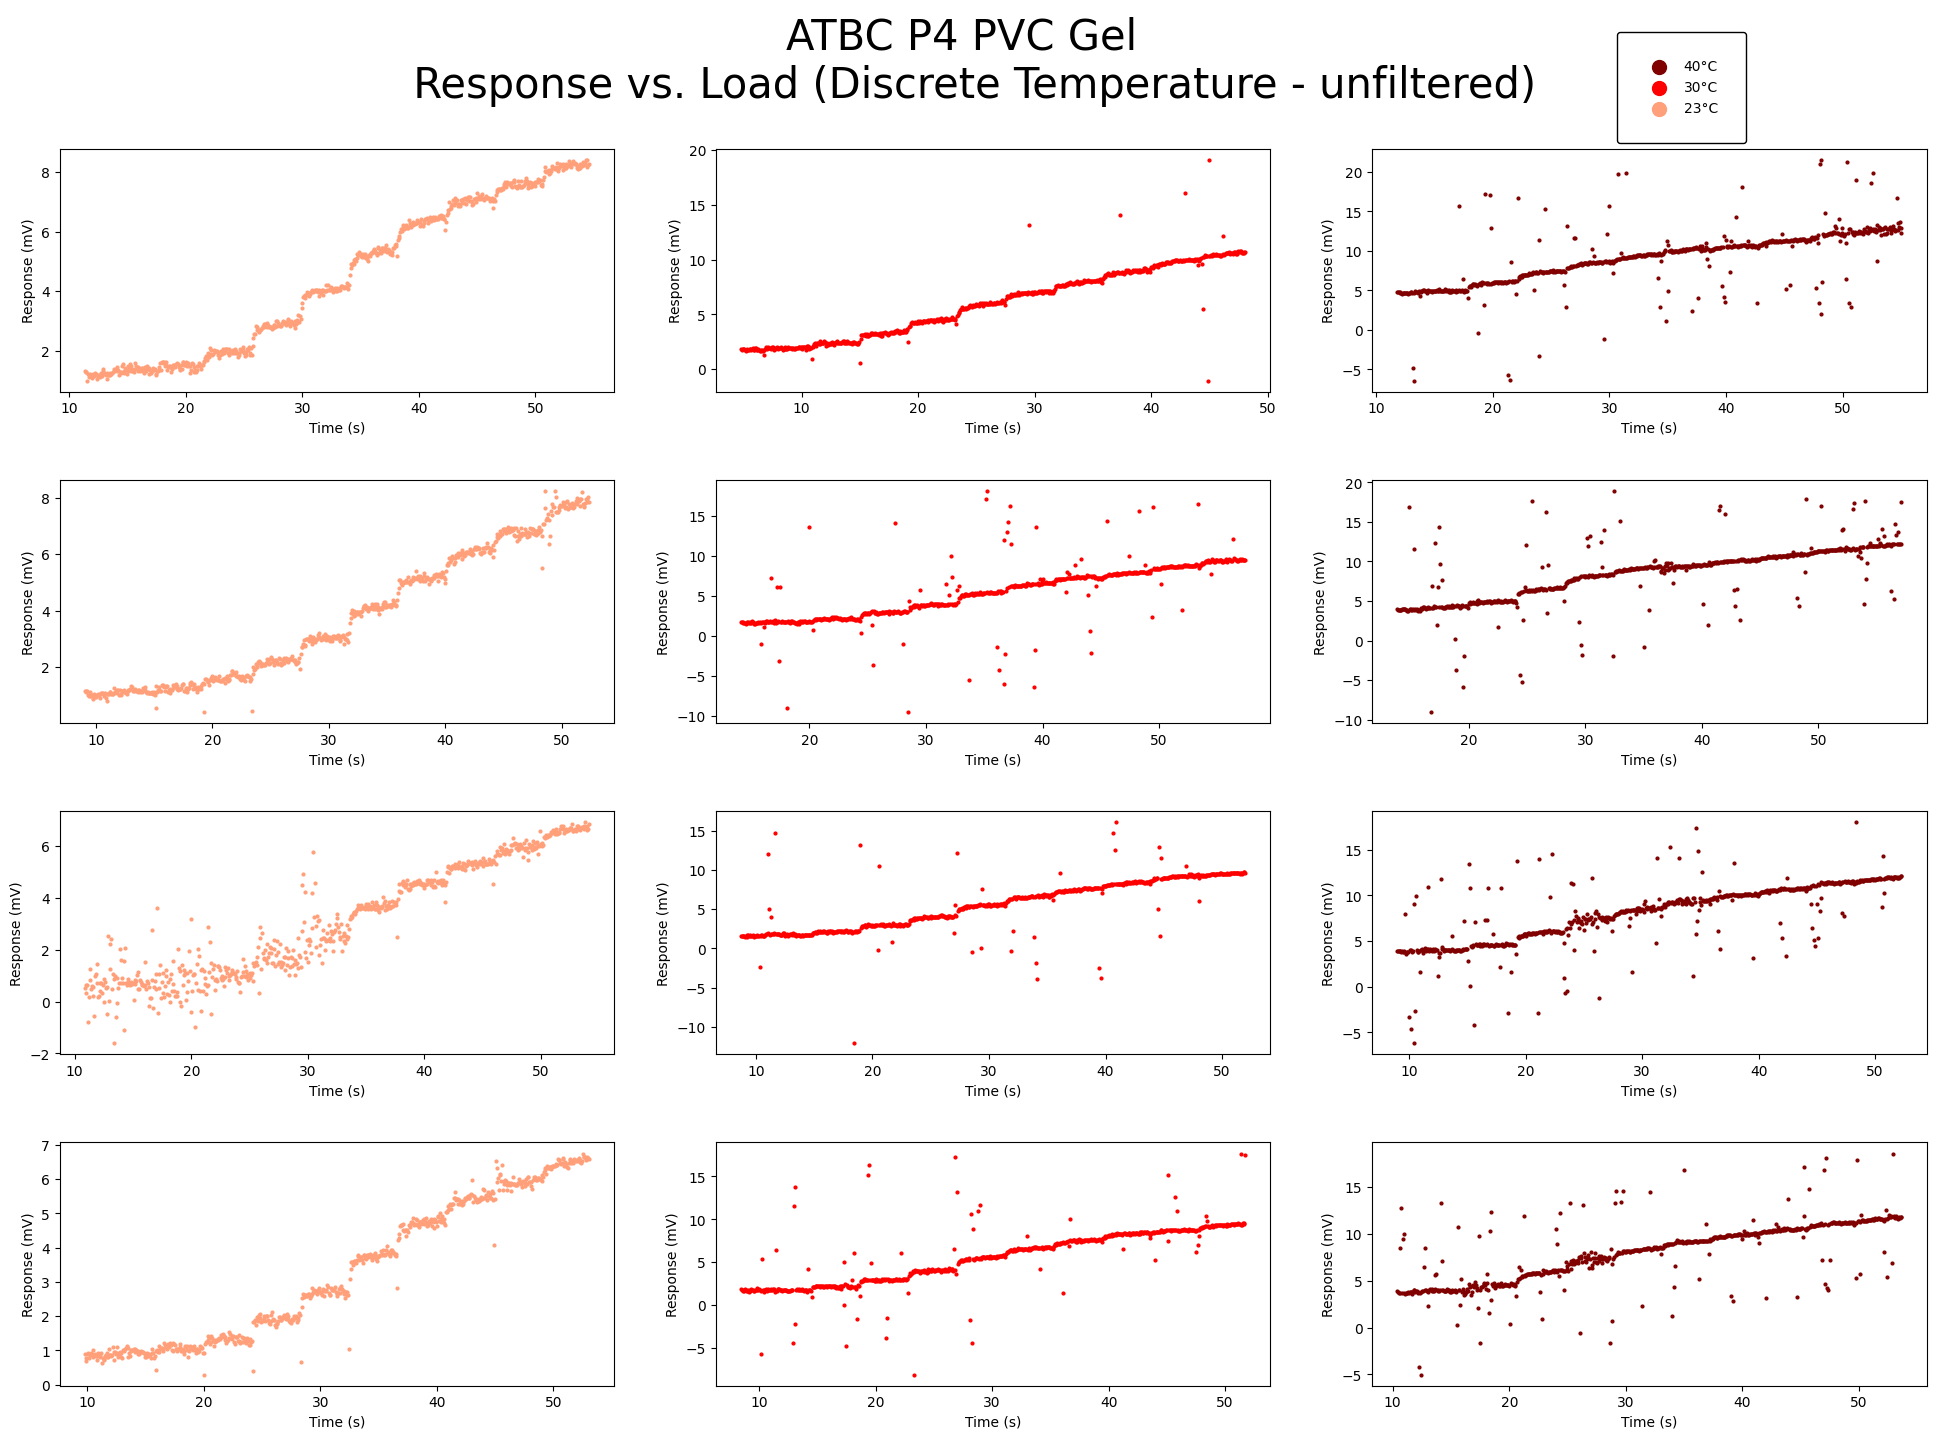

In [4]:

#############################################################################! Remove noise before Savitzky-Golay Filter #########################################################################################################################
xlabel = 'Time (s)'
ylabel = 'Response (mV)'

# Set dimension of number of graphs used for figure 

fig, ax = plt.subplots(nrows=4, ncols=3)
fig.set_figheight(15)
fig.set_figwidth(20)
fig.suptitle('ATBC P4 PVC Gel \n Response vs. Load (Discrete Temperature - unfiltered)', fontsize = 30, y = .97)

i = 0
for csv_file in os.listdir(directory)[0:4]:
    trimmed_df = trim_data(f't1e{i+1}.csv')
    ax[i,0].scatter(trimmed_df['Relative Time'], trimmed_df['Response (mV)'], c = 'lightsalmon', s=4)
    ax[i,0].set_xlabel(xlabel)
    ax[i,0].set_ylabel(ylabel)
    i += 1

i = 0
for csv_file in os.listdir(directory)[4:8]:
    trimmed_df = trim_data(f't2e{i+1}.csv')
    ax[i,1].scatter(trimmed_df['Relative Time'], trimmed_df['Response (mV)'], c = 'red', s=4)
    ax[i,1].set_xlabel(xlabel)
    ax[i,1].set_ylabel(ylabel)
    i += 1


i = 0
for csv_file in os.listdir(directory)[8:12]:
    trimmed_df = trim_data(f't3e{i+1}.csv')
    ax[i,2].scatter(trimmed_df['Relative Time'], trimmed_df['Response (mV)'], c = 'maroon', s=4)
    ax[i,2].set_xlabel(xlabel)
    ax[i,2].set_ylabel(ylabel)
    i += 1


# Change legend marker size
lgnd = fig.legend(['40°C', '30°C', '23°C'], framealpha = 1, borderpad = 2, loc = (0.835, 0.9))
for handle in lgnd.legend_handles:
   handle.set_sizes([100])

# Manually change legend color
lgnd.legend_handles[0].set_color('maroon')
lgnd.legend_handles[1].set_color('red')
lgnd.legend_handles[2].set_color('lightsalmon')
lgnd.get_frame().set_edgecolor('black')

fig.tight_layout(pad=3.0)

#! Save image
plt.savefig(r"C:\Users\asenn\OneDrive\School\Research\MSIPP (Georgia 2023)\Plots\Grid (Noisy) - Response vs. Time (all trials).jpg", format="jpg", dpi=1200)


# Grid: LocalOutlierProability outliers removed 4 x 3 grid

C:\Users\asenn\AppData\Local\Temp\ipykernel_25944\2627318467.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df_trimmed.rename({'CH110':'Load (g)', 'CH108':'Response (mV)'}, inplace=True, axis = 1)
c:\Users\asenn\pycode\pyprojects\pvc-gels\.venv.pvc-gels\Lib\site-packages\PyNomaly\loop.py:332: UserWarning: Argument 'extent' is not of type (<class 'int'>, <class 'numpy.integer'>).
  warnings.warn("Argument %r is not of type %s." % (
c:\Users\asenn\pycode\pyprojects\pvc-gels\.venv.pvc-gels\Lib\site-packages\PyNomaly\loop.py:224: UserWarning: extent parameter (lambda) must be 1, 2, or 3.
  warnings.warn(
C:\Users\asenn\AppData\Local\Temp\ipykernel_25944\2627318467.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

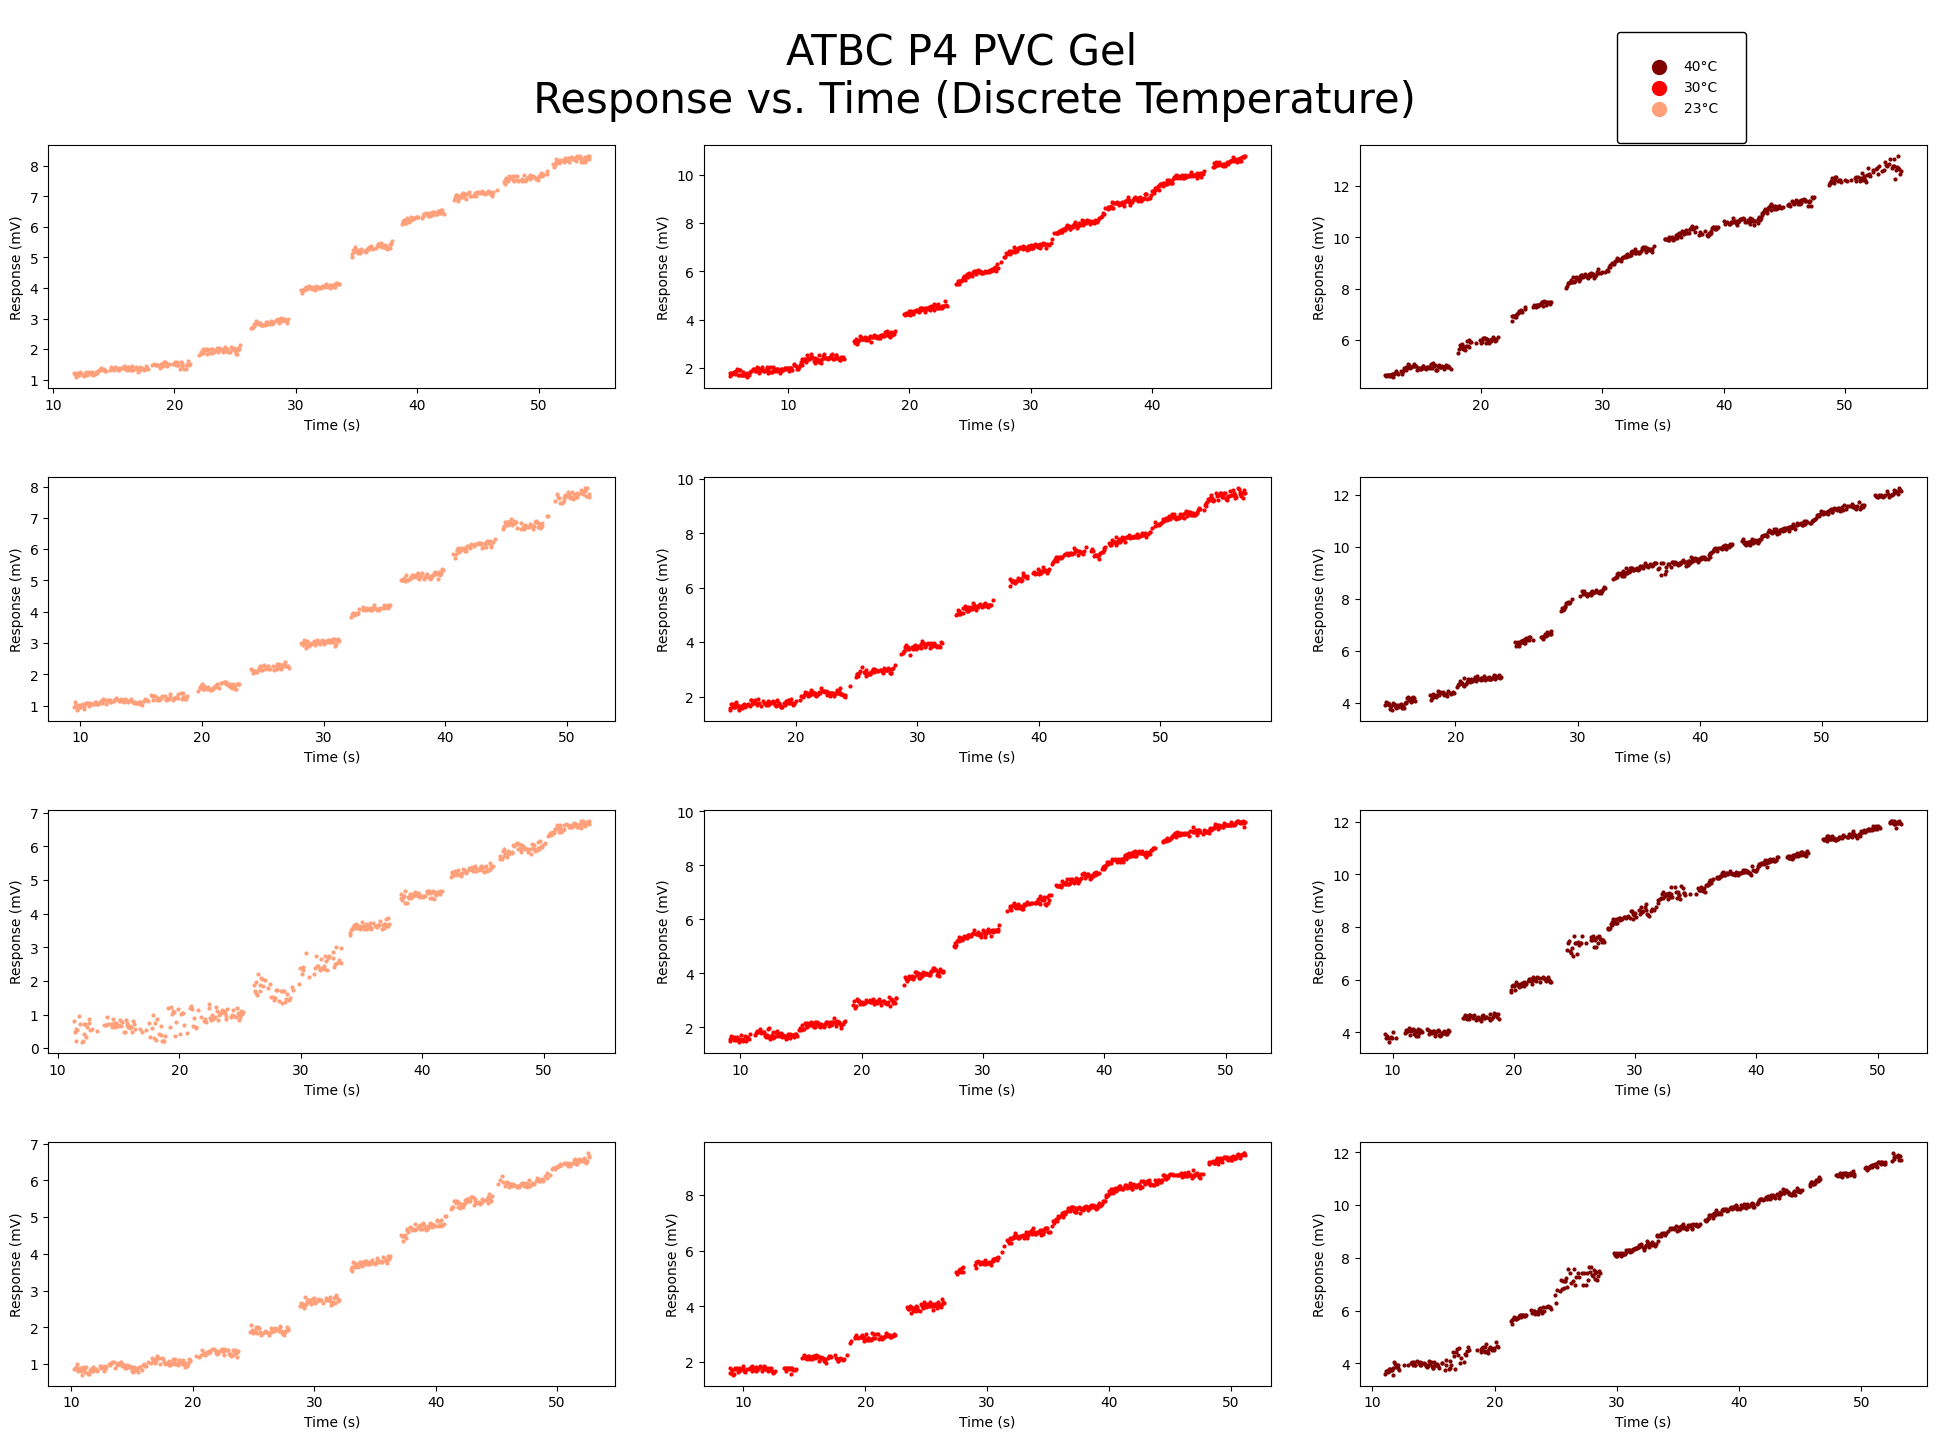

In [5]:

#!#######################################################################################################################

# Set dimension of number of graphs used for figure 

filtered_df_list = [] # Initialize list to store filtered dataframes 

fig, ax = plt.subplots(nrows=4, ncols=3)
fig.set_figheight(15)
fig.set_figwidth(20)
fig.suptitle('ATBC P4 PVC Gel \n Response vs. Time (Discrete Temperature)', fontsize = 30, y = .96)

# threshold to drop data points based on the probablity that they are outliers
lop_score_threshold = 0.2

# Set xlabel and ylabel for all graphs
xlabel = 'Time (s)'
ylabel = 'Response (mV)'

i = 0
for csv_file in os.listdir(directory)[0:4]:
    lop_df = trim_data(f't1e{i+1}.csv')
    m = loop.LocalOutlierProbability(lop_df.drop(columns='Load (g)'), extent=.25, n_neighbors = 20).fit() # Used to find scores
    scores = m.local_outlier_probabilities # this is an attribute after performing LocalOutlierProbability()
    lop_df['scores'] = scores.tolist() # Adding scores to lop_df
    filtered_df = lop_df.query(f'scores < {lop_score_threshold}') # Final df with dropped outliers
    filtered_df_list.append(filtered_df)
    ax[i,0].scatter(lop_df.query(f'scores < {lop_score_threshold}')['Relative Time'], lop_df.query(f'scores < {lop_score_threshold}')['Response (mV)'], c = 'lightsalmon', s=4 )
    ax[i,0].set_xlabel(xlabel)
    ax[i,0].set_ylabel(ylabel)
    i += 1


i = 0
for csv_file in os.listdir(directory)[4:8]:
    lop_df = trim_data(f't2e{i+1}.csv')
    m = loop.LocalOutlierProbability(lop_df.drop(columns='Load (g)'), extent=.25, n_neighbors = 20).fit() # Used to find scores
    scores = m.local_outlier_probabilities # this is an attribute after performing LocalOutlierProbability()
    lop_df['scores'] = scores.tolist() # Adding scores to lop_df
    filtered_df = lop_df.query(f'scores < {lop_score_threshold}') # Final df with dropped outliers
    filtered_df_list.append(filtered_df)
    ax[i,1].scatter(lop_df.query(f'scores < {lop_score_threshold}')['Relative Time'], lop_df.query(f'scores < {lop_score_threshold}')['Response (mV)'], c = 'red', s=4 )
    ax[i,1].set_xlabel(xlabel)
    ax[i,1].set_ylabel(ylabel)
    i += 1



i = 0
for csv_file in os.listdir(directory)[8:12]:
    lop_df = trim_data(f't3e{i+1}.csv')
    m = loop.LocalOutlierProbability(lop_df.drop(columns='Load (g)'), extent=.25, n_neighbors = 20).fit() # Used to find scores
    scores = m.local_outlier_probabilities # this is an attribute after performing LocalOutlierProbability()
    lop_df['scores'] = scores.tolist() # Adding scores to lop_df
    filtered_df = lop_df.query(f'scores < {lop_score_threshold}') # Final df with dropped outliers
    filtered_df_list.append(filtered_df)
    ax[i,2].scatter(lop_df.query(f'scores < {lop_score_threshold}')['Relative Time'], lop_df.query(f'scores < {lop_score_threshold}')['Response (mV)'], c = 'maroon', s=4 )
    ax[i,2].set_xlabel(xlabel)
    ax[i,2].set_ylabel(ylabel)
    i += 1




# Change legend marker size
lgnd = fig.legend(['40°C', '30°C', '23°C'], framealpha = 1, borderpad = 2, loc = (0.835, 0.9))
for handle in lgnd.legend_handles:
   handle.set_sizes([100])

# Manually change legend color
lgnd.legend_handles[0].set_color('maroon')
lgnd.legend_handles[1].set_color('red')
lgnd.legend_handles[2].set_color('lightsalmon')
lgnd.get_frame().set_edgecolor('black')

fig.tight_layout(pad=3.0)

# #! Save image
plt.savefig(r"C:\Users\asenn\OneDrive\School\Research\MSIPP (Georgia 2023)\Plots\Grid (LOP) - Response vs. Time (all trials).jpg", format="jpg", dpi=1200)



# Grid: Resp. vs Load (filtered data used)

12


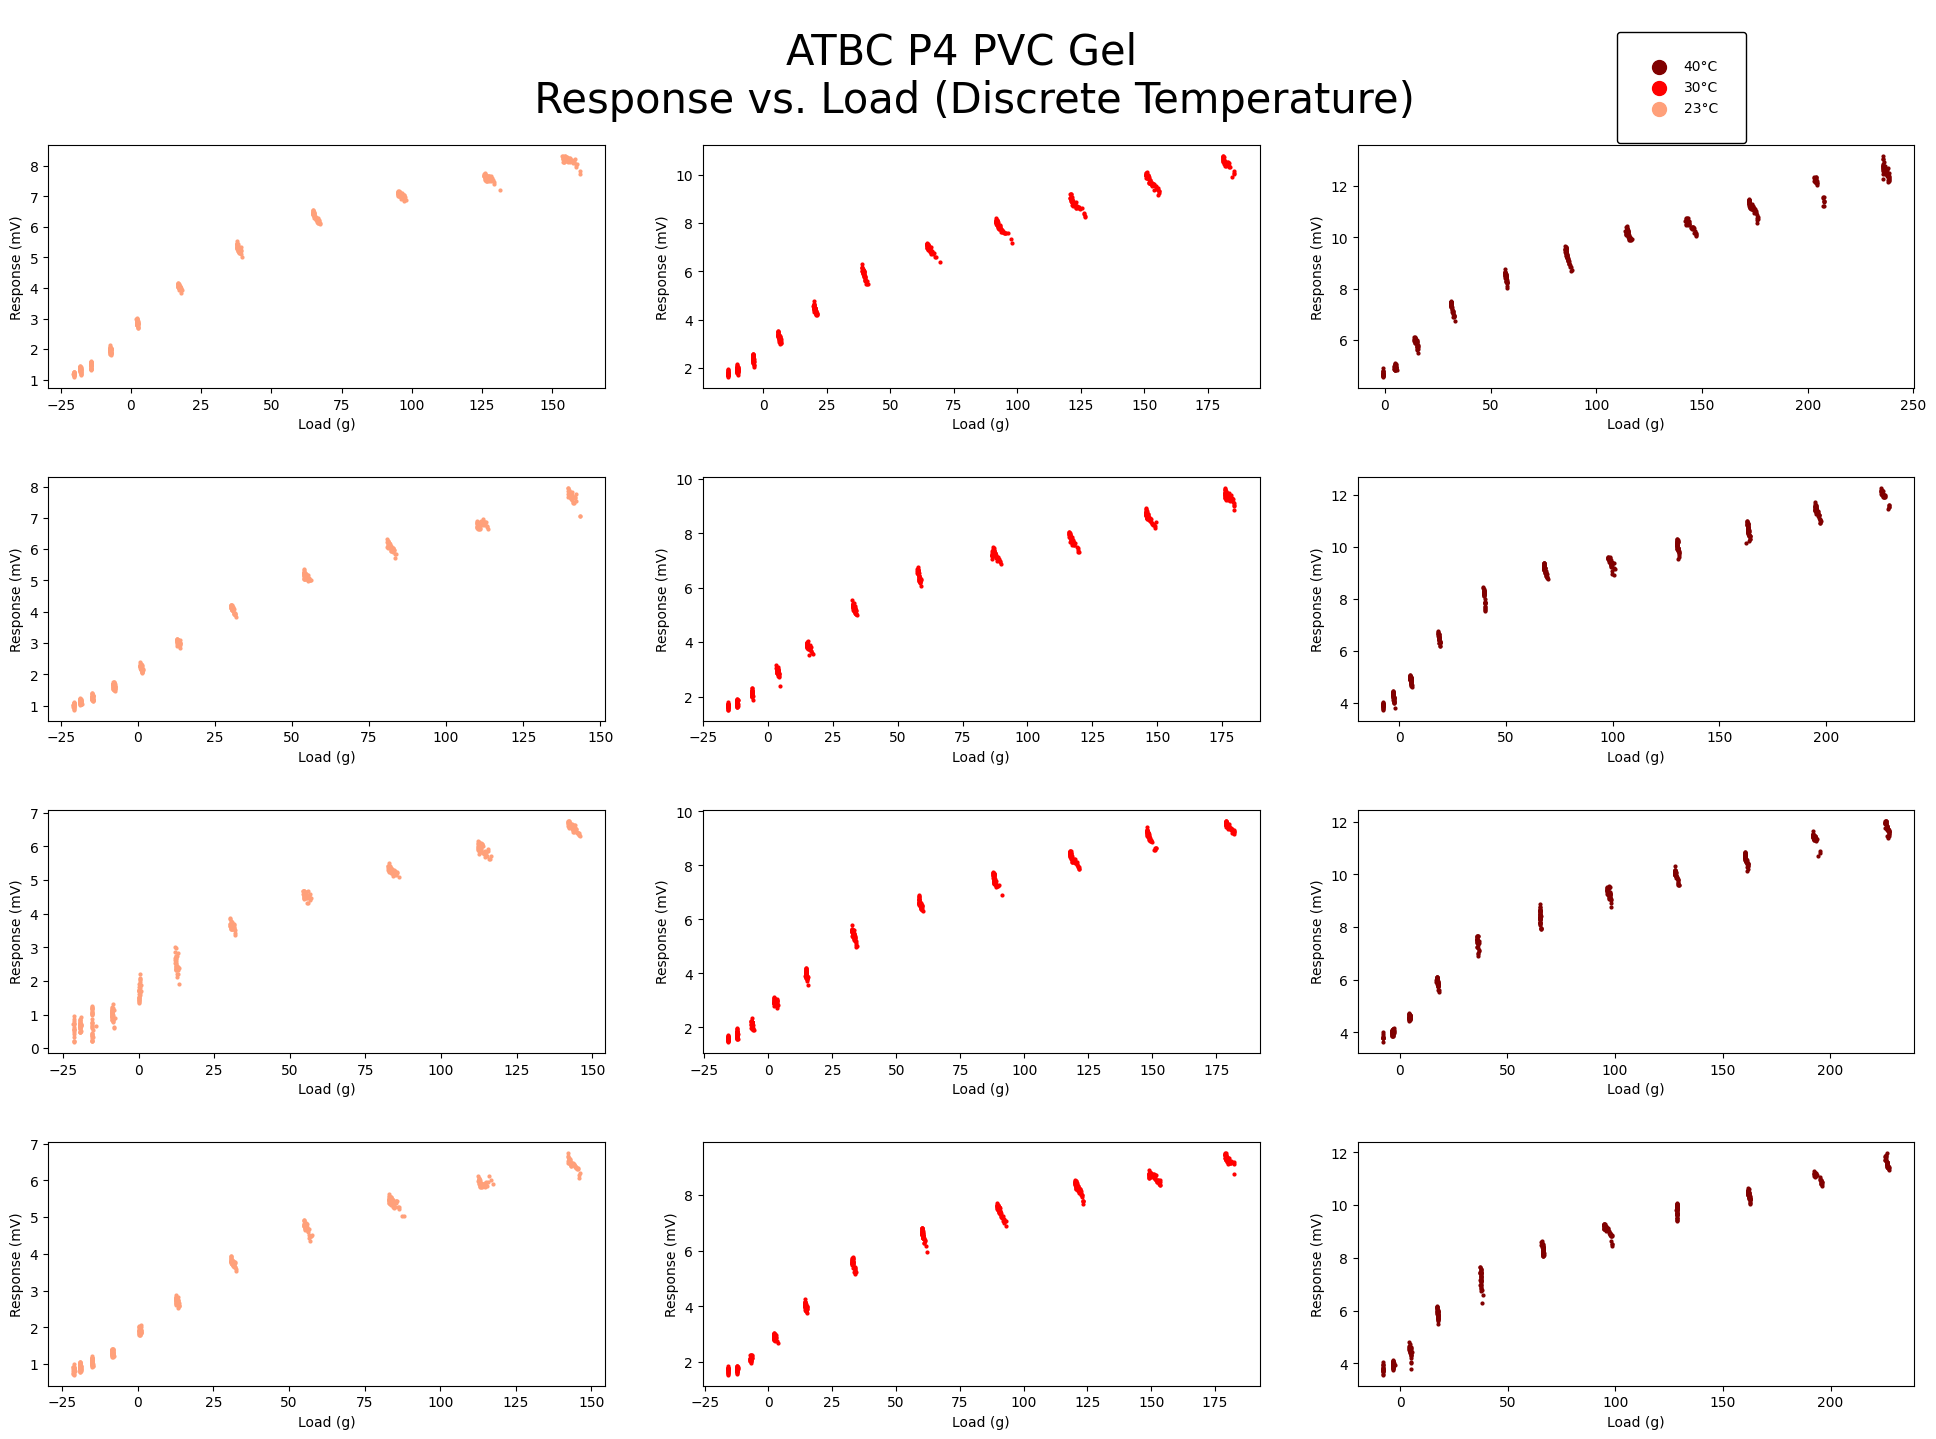

In [40]:
fig, ax = plt.subplots(nrows=4, ncols=3)
fig.set_figheight(15)
fig.set_figwidth(20)
fig.suptitle('ATBC P4 PVC Gel \n Response vs. Load (Discrete Temperature)', fontsize = 30, y = .96)


xlabel = 'Load (g)'
ylabel = 'Response (mV)'

i = 0
for filtered_df in filtered_df_list[0:4]:
    if i < 4:
        ax[i,0].scatter(filtered_df['Load (g)'], filtered_df['Response (mV)'], c = 'lightsalmon', s=4 )
        ax[i,0].set_xlabel(xlabel)
        ax[i,0].set_ylabel(ylabel)
        i += 1

i = 0
for filtered_df in filtered_df_list[4:8]:
    if i < 4:
        ax[i,1].scatter(filtered_df['Load (g)'], filtered_df['Response (mV)'], c = 'red', s=4 )
        ax[i,1].set_xlabel(xlabel)
        ax[i,1].set_ylabel(ylabel)
        i += 1

i = 0
for filtered_df in filtered_df_list[8:12]:
    if i < 4:
        ax[i,2].scatter(filtered_df['Load (g)'], filtered_df['Response (mV)'], c = 'maroon', s=4 )
        ax[i,2].set_xlabel(xlabel)
        ax[i,2].set_ylabel(ylabel)
        i += 1



# Change legend marker size
lgnd = fig.legend(['40°C', '30°C', '23°C'], framealpha = 1, borderpad = 2, loc = (0.835, 0.9))
for handle in lgnd.legend_handles:
   handle.set_sizes([100])

# Manually change legend color
lgnd.legend_handles[0].set_color('maroon')
lgnd.legend_handles[1].set_color('red')
lgnd.legend_handles[2].set_color('lightsalmon')
lgnd.get_frame().set_edgecolor('black')
fig.tight_layout(pad=3.0)

print(len(filtered_df_list))



# One graph: Load domain (LOP filtered data)

C:\Users\asenn\AppData\Local\Temp\ipykernel_25944\2627318467.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df_trimmed.rename({'CH110':'Load (g)', 'CH108':'Response (mV)'}, inplace=True, axis = 1)
C:\Users\asenn\AppData\Local\Temp\ipykernel_25944\2627318467.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df_trimmed.rename({'CH110':'Load (g)', 'CH108':'Response (mV)'}, inplace=True, axis = 1)
C:\Users\asenn\AppData\Local\Temp\ipykernel_25944\2627318467.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pand

['_A', '_PROPERTIES_EXCLUDED_FROM_SET', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_agg_filter', '_alias_map', '_alpha', '_animated', '_antialiaseds', '_axes', '_bcast_lwls', '_callbacks', '_capstyle', '_clipon', '_clippath', '_cm_set', '_default_contains', '_edge_default', '_edge_is_mapped', '_edgecolors', '_face_is_mapped', '_facecolors', '_factor', '_fully_clipped_to_axes', '_get_default_antialiased', '_get_default_edgecolor', '_get_default_facecolor', '_get_default_linewidth', '_gid', '_hatch', '_hatch_color', '_id_norm', '_in_layout', '_internal_update', '_joinstyle', '_label', '_linestyles', '_linewidths', '_mapped_colors', '_mouseover', '_norm', '_offset_transform', 

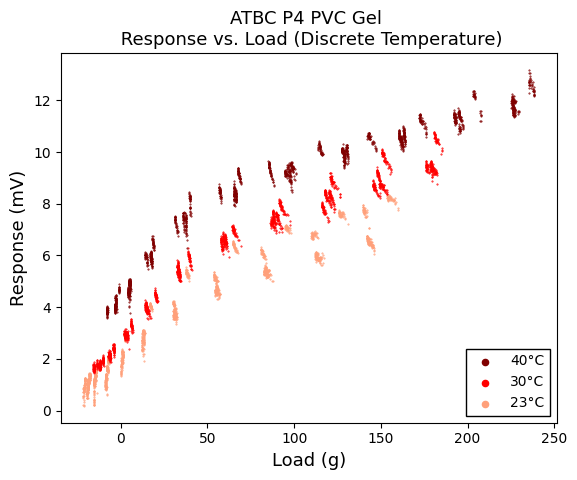

In [6]:

fig, ax = plt.subplots()
ax.set_ylabel('Response (mV)', fontsize = 13)  # a figure with a single Axes
ax.set_xlabel('Load (g)', fontsize = 13)
ax.set_title('ATBC P4 PVC Gel \n Response vs. Load (Discrete Temperature)', fontsize = 13)



for filtered_df in filtered_df_list[0:4]:
    ax.scatter(filtered_df['Load (g)'], filtered_df['Response (mV)'], c = 'lightsalmon', s=.2)
        
for filtered_df in filtered_df_list[4:8]:
    trimmed_df = trim_data(csv_file)
    ax.scatter(filtered_df['Load (g)'], filtered_df['Response (mV)'], c = 'red', s=.2)
        
for filtered_df in filtered_df_list[8:12]:
    trimmed_df = trim_data(csv_file)
    ax.scatter(filtered_df['Load (g)'], filtered_df['Response (mV)'], c = 'maroon', s=.2)


# Change legend marker size
lgnd = ax.legend(['40°C', '30°C', '23°C'], framealpha = 1, fancybox = False, loc = 'lower right')
for handle in lgnd.legend_handles:
    handle.set_sizes([20])

# Manually change legend color
ax.get_legend().legend_handles[0].set_color('maroon')
ax.get_legend().legend_handles[1].set_color('red')
ax.get_legend().legend_handles[2].set_color('lightsalmon')
lgnd.get_frame().set_edgecolor('black')
# plt.legend().legend_handles.set_sizes([30])
# ax.get_legend().legend_handles[1].set_sizes(30) 
# ax.get_legend().legend_handles[2].set_sizes(30) 
print(dir(ax.get_legend().legend_handles[2]))
print(ax)

# #! Save image
plt.savefig(r"C:\Users\asenn\OneDrive\School\Research\MSIPP (Georgia 2023)\Plots\One graph (LOP) - Response vs. Load (all trials).jpg", format="jpg", dpi=1200)

# One graph: Time domain (LOP filtered data)

C:\Users\asenn\AppData\Local\Temp\ipykernel_16012\3538886105.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df_trimmed.rename({'CH110':'Load (g)', 'CH108':'Response (mV)'}, inplace=True, axis = 1)
C:\Users\asenn\AppData\Local\Temp\ipykernel_16012\3538886105.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df_trimmed.rename({'CH110':'Load (g)', 'CH108':'Response (mV)'}, inplace=True, axis = 1)
C:\Users\asenn\AppData\Local\Temp\ipykernel_16012\3538886105.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pand

['_A', '_PROPERTIES_EXCLUDED_FROM_SET', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_agg_filter', '_alias_map', '_alpha', '_animated', '_antialiaseds', '_axes', '_bcast_lwls', '_callbacks', '_capstyle', '_clipon', '_clippath', '_cm_set', '_default_contains', '_edge_default', '_edge_is_mapped', '_edgecolors', '_face_is_mapped', '_facecolors', '_factor', '_fully_clipped_to_axes', '_get_default_antialiased', '_get_default_edgecolor', '_get_default_facecolor', '_get_default_linewidth', '_gid', '_hatch', '_hatch_color', '_id_norm', '_in_layout', '_internal_update', '_joinstyle', '_label', '_linestyles', '_linewidths', '_mapped_colors', '_mouseover', '_norm', '_offset_transform', 

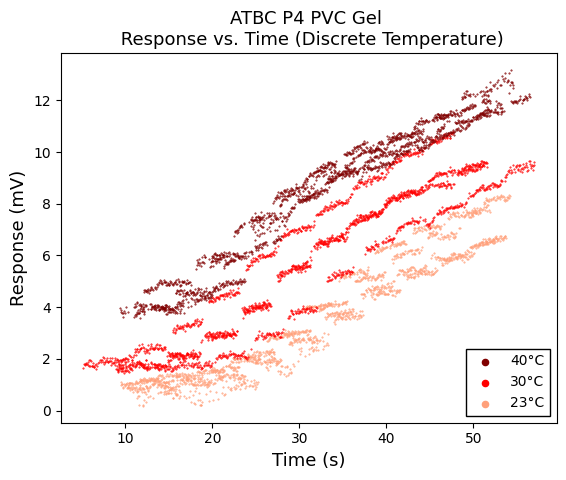

In [41]:

fig, ax = plt.subplots()
ax.set_ylabel('Response (mV)', fontsize = 13)  # a figure with a single Axes
ax.set_xlabel('Time (s)', fontsize = 13)
ax.set_title('ATBC P4 PVC Gel \n Response vs. Time (Discrete Temperature)', fontsize = 13)



for filtered_df in filtered_df_list[0:4]:
    ax.scatter(filtered_df['Relative Time'], filtered_df['Response (mV)'], c = 'lightsalmon', s=.2)
        
for filtered_df in filtered_df_list[4:8]:
    trimmed_df = trim_data(csv_file)
    ax.scatter(filtered_df['Relative Time'], filtered_df['Response (mV)'], c = 'red', s=.2)
        
for filtered_df in filtered_df_list[8:12]:
    trimmed_df = trim_data(csv_file)
    ax.scatter(filtered_df['Relative Time'], filtered_df['Response (mV)'], c = 'maroon', s=.2)


# Change legend marker size
lgnd = ax.legend(['40°C', '30°C', '23°C'], framealpha = 1, fancybox = False, loc = 'lower right')
for handle in lgnd.legend_handles:
    handle.set_sizes([20])

# Manually change legend color
ax.get_legend().legend_handles[0].set_color('maroon')
ax.get_legend().legend_handles[1].set_color('red')
ax.get_legend().legend_handles[2].set_color('lightsalmon')
lgnd.get_frame().set_edgecolor('black')
# plt.legend().legend_handles.set_sizes([30])
# ax.get_legend().legend_handles[1].set_sizes(30) 
# ax.get_legend().legend_handles[2].set_sizes(30) 
print(dir(ax.get_legend().legend_handles[2]))
print(ax)

# #! Save image
plt.savefig(r"C:\Users\asenn\OneDrive\School\Research\MSIPP (Georgia 2023)\Plots\One graph (LOP) - Response vs. Time (all trials).jpg", format="jpg", dpi=1200)

# Random .pdf to .jpg conversion script

In [189]:
from pdf2image import convert_from_path

# import required module
import os
dates_list = ['4.2', '6.12', '6.13', '6.15', '6.19', '6.21', '6.24', '6.26', '6.28', '6.29']

dunder = []
i = 0
for day in dates_list:   
    dunder.append(dates_list[i].replace('.', '_'))
    i += 1

print(dates_list)
print(dunder)

for day in dunder:
    date = f'{day}_23'
    file_name = f'{date}.jpg'
    old_file_name = file_name.replace('_', '.').replace('.jpg', '.pdf') 
    # assign directory
    directory = r'C:\\Users\\asenn\\OneDrive\\Dhamma\\Journaling\\old\\{}'.format(old_file_name)
    print(f"old_file_name: {directory}")
    output_file = r'C:\\Users\\asenn\\OneDrive\\Dhamma\\Journaling\\test\\Date{}'.format(file_name)
    print(output_file)
    pages = convert_from_path(directory, poppler_path = r"C:\Users\asenn\Downloads\Release-23.05.0-0\poppler-23.05.0\Library\bin", output_folder=r'C:\\Users\\asenn\\OneDrive\\Dhamma\\Journaling\\test\\', output_file = r'{}'.format(file_name), dpi = 400, fmt='jpg')
    
# for count, page in enumerate(pages):
#     page.save(f'out{count}.jpg', 'JPEG')


# MyID = 'X12345'    
# MasterFile_Name = r'Users\ABC\{}\DEF\File - Test.xlsx'.format(MyID)    
# print(MasterFile_Name)

['4.2', '6.12', '6.13', '6.15', '6.19', '6.21', '6.24', '6.26', '6.28', '6.29']
['4_2', '6_12', '6_13', '6_15', '6_19', '6_21', '6_24', '6_26', '6_28', '6_29']
old_file_name: C:\\Users\\asenn\\OneDrive\\Dhamma\\Journaling\\old\\4.2.23.pdf
C:\\Users\\asenn\\OneDrive\\Dhamma\\Journaling\\test\\Date4_2_23.jpg
old_file_name: C:\\Users\\asenn\\OneDrive\\Dhamma\\Journaling\\old\\6.12.23.pdf
C:\\Users\\asenn\\OneDrive\\Dhamma\\Journaling\\test\\Date6_12_23.jpg
old_file_name: C:\\Users\\asenn\\OneDrive\\Dhamma\\Journaling\\old\\6.13.23.pdf
C:\\Users\\asenn\\OneDrive\\Dhamma\\Journaling\\test\\Date6_13_23.jpg
old_file_name: C:\\Users\\asenn\\OneDrive\\Dhamma\\Journaling\\old\\6.15.23.pdf
C:\\Users\\asenn\\OneDrive\\Dhamma\\Journaling\\test\\Date6_15_23.jpg
old_file_name: C:\\Users\\asenn\\OneDrive\\Dhamma\\Journaling\\old\\6.19.23.pdf
C:\\Users\\asenn\\OneDrive\\Dhamma\\Journaling\\test\\Date6_19_23.jpg
old_file_name: C:\\Users\\asenn\\OneDrive\\Dhamma\\Journaling\\old\\6.21.23.pdf
C:\\Users\\a

In [199]:
files_list = []

for file in os.listdir(r"C:\\Users\\asenn\\OneDrive\\Dhamma\\Journaling\\old"):
    files_list.append(file.replace('.pdf', '.jpg'))

for file in files_list:
    print (file)

4.2.23.jpg
6.12.23.jpg
6.13.23.jpg
6.15.23.jpg
6.19.23.jpg
6.21.23.jpg
6.24.23.jpg
6.26.23.jpg
6.28.23.jpg
6.29.23.jpg
8.1.22.jpg
8.22.23.jpg
8.5.22.jpg
8.6.22.jpg
